In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load data
df = pd.read_csv("d:/Genre Classification Dataset/train_data.txt", delimiter=('::: '), engine="python", header=None, names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])
df['combined_text'] = df['ID'].astype(str) + '  ' + df['TITLE'] + '  ' + df['DESCRIPTION']

In [3]:
df.head()

,ID,TITLE,GENRE,DESCRIPTION,combined_text
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,1 Oscar et la dame rose (2009) Listening in...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,2 Cupid (1997) A brother and sister with a ...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,"3 Young, Wild and Wonderful (1980) As the b..."
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,4 The Secret Sin (1915) To help their unemp...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,5 The Unrecovered (2007) The film's title r...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             54214 non-null  int64 
 1   TITLE          54214 non-null  object
 2   GENRE          54214 non-null  object
 3   DESCRIPTION    54214 non-null  object
 4   combined_text  54214 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


There are movies of 27 genre in the database
GENRE
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
family            784
adventure         775
music             731
romance           672
sci-fi            647
adult             590
crime             505
animation         498
sport             432
talk-show         391
fantasy           323
mystery           319
musical           277
biography         265
history           243
game-show         194
news              181
war               132
Name: count, dtype: int64


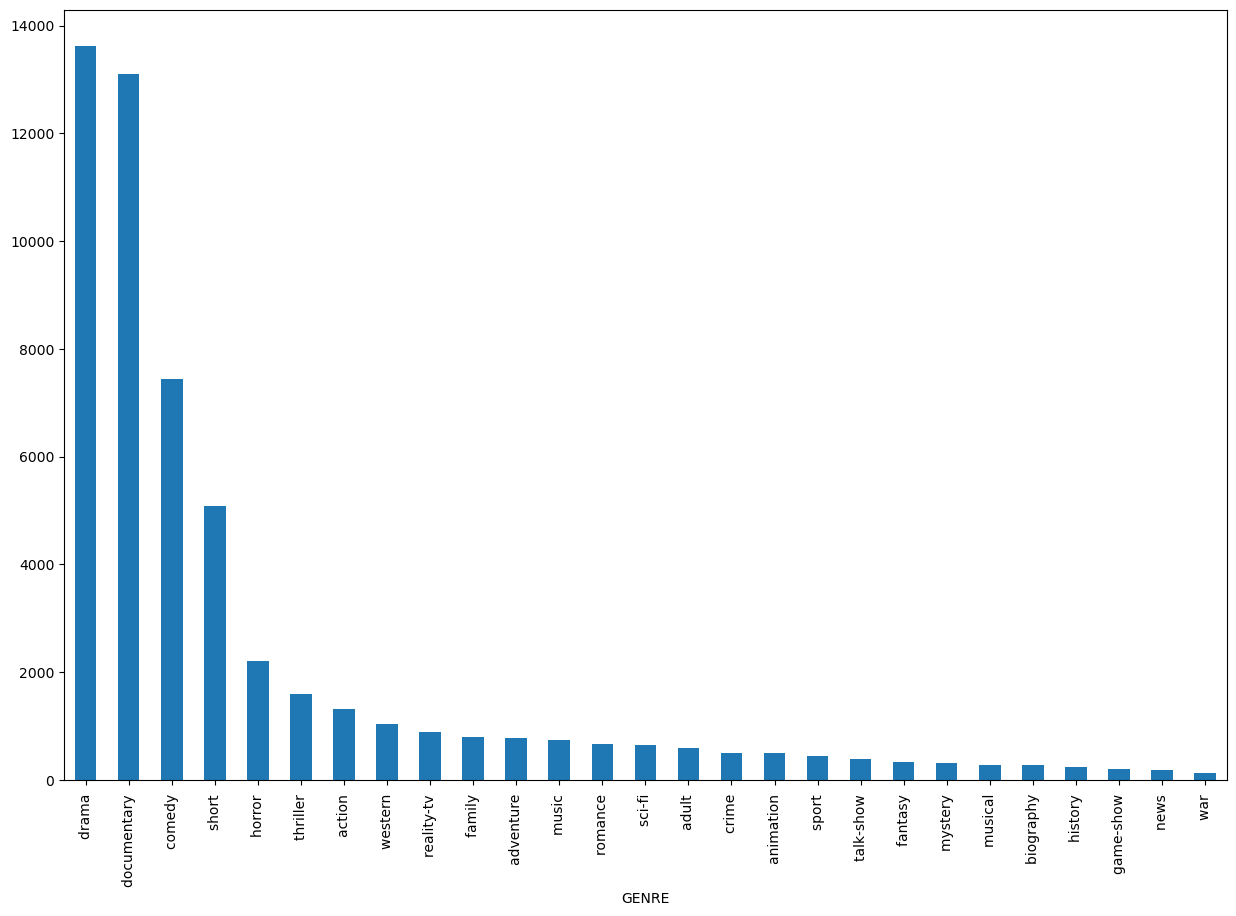

In [4]:
print("There are movies of {} genre in the database".format(df.loc[:,"GENRE"].nunique()))
plt.figure(figsize=(15,10))
df.loc[:,"GENRE"].value_counts().plot.bar()
print(df.GENRE.value_counts())

In [5]:
# Text cleaning function
from nltk.stem import WordNetLemmatizer
wlen = WordNetLemmatizer()
sw = stopwords.words('english')
sw.remove('not')

def text_cleaning(doc):
    doc = doc.lower()
    doc = re.sub("[^a-z]", " ", doc)
    tokens = word_tokenize(doc)
    new_doc = [wlen.lemmatize(token) for token in tokens if token not in sw]
    return ' '.join(new_doc)

In [6]:
# Prepare data
X = df['combined_text']
y = df['GENRE']

In [7]:
# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.2)

In [10]:
# Clean text data
X_train_clean = list(map(text_cleaning, X_train))
X_test_clean = list(map(text_cleaning, X_test))

In [11]:
# Vectorize text data
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features=5000, ngram_range=(1, 2)) # Experiment with these parameters
X_train_matrix = cv.fit_transform(X_train_clean)
X_test_matrix = cv.transform(X_test_clean)

In [12]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
model=MultinomialNB()
model.fit(X_train_matrix,y_train)

MultinomialNB()

In [13]:
train_score = model.score(X_train_matrix, y_train)
test_score = model.score(X_test_matrix, y_test)
print("Training score:", train_score)
print("Test score:", test_score)

Training score: 0.5505060985451108
Test score: 0.5302038181315134


In [14]:
# Model training and evaluation
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='saga', max_iter=1000, C=0.5) # Experiment with the C parameter
model.fit(X_train_matrix, y_train)

LogisticRegression(C=0.5, max_iter=1000, solver='saga')

In [15]:
# Evaluate model
train_score = model.score(X_train_matrix, y_train)
test_score = model.score(X_test_matrix, y_test)
print("Training score:", train_score)
print("Test score:", test_score)

Training score: 0.634179520878006
Test score: 0.5808355621138062


In [16]:
# Cross-validation
cv_scores = cross_val_score(model, X_train_matrix, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Average cross-validation score:", np.mean(cv_scores))

Cross-validation scores: [0.56818444 0.56848052 0.56156329 0.56974867 0.56629006]
Average cross-validation score: 0.5668533967157472


In [17]:
import joblib
joblib.dump(model,"MovieGenre_prediction_model")

['MovieGenre_prediction_model']

In [19]:
model=joblib.load("MovieGenre_prediction_model")
# Load and preprocess test data
df_test = pd.read_csv("d:/Genre Classification Dataset/test_data.txt", delimiter=(':::'), engine="python", header=None, names=['ID', 'TITLE', 'DESCRIPTION'])
df_test['combined_text'] = df_test['TITLE'] + '  ' + df_test['DESCRIPTION']
test_new = list(map(text_cleaning, df_test['combined_text']))
clean_test = cv.transform(test_new)
predictions = model.predict(clean_test)

In [20]:
# Convert numeric predictions back to genre labels
predicted_genres = le.inverse_transform(predictions)

In [21]:
# Combine predictions with test data
pred1 = [(x, y) for x, y in zip(df_test['combined_text'], predicted_genres)]
pred1

[(" Edgar's Lunch (1998)    L.R. Brane loves his life - his car, his apartment, his job, but especially his girlfriend, Vespa. One day while showering, Vespa runs out of shampoo. L.R. runs across the street to a convenience store to buy some more, a quick trip of no more than a few minutes. When he returns, Vespa is gone and every trace of her existence has been wiped out. L.R.'s life becomes a tortured existence as one strange event after another occurs to confirm in his mind that a conspiracy is working against his finding Vespa.",
  'comedy '),
 (' La guerra de papá (1977)    Spain, March 1964: Quico is a very naughty child of three belonging to a wealthy middle-class family. Since Cristina\'s birth, he feels he has lost the privileged position of "prince" of the house for his eight months old sister. So, with his brother Juan, who is eight years old and is quite disobedient, spend their time committing prank after prank, causing the resulting anger of his mother, the nanny and the 